In [49]:
import torch
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, sampler
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

In [50]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.49139969, 0.48215842, 0.44653093], [0.20220212, 0.19931542, 0.20086347])
])
training_data = CIFAR10('cifar/train', train=True, download=True, transform=transform)
test_data = CIFAR10('cifar/test', train=False, download=True, transform=transform)
loader = DataLoader(training_data, 32, sampler=sampler.SubsetRandomSampler(range(49000)))
loader_val = DataLoader(training_data, 32, sampler=sampler.SubsetRandomSampler(range(49000,50000)))
loader_test = DataLoader(test_data, 32)

Files already downloaded and verified
Files already downloaded and verified


In [48]:
#calculate dataset mean and std per channel to feed to transform normalization params
def calc_normalize_values():
    means = np.zeros(3)
    stds = np.zeros(3)
    N = len(training_data)
    for i, (data, label) in enumerate(training_data):
        means += data.numpy().mean(axis=(1,2))
        stds += data.numpy().std(axis=(1,2))
    means /= N
    stds /= N
    print(means, stds)
calc_normalize_values()

KeyboardInterrupt: 

In [51]:
(data, labels) = next(iter(loader))
print(data.shape)

torch.Size([32, 3, 32, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


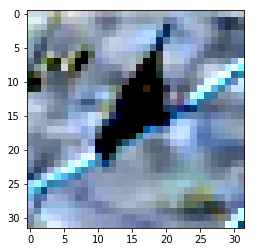

In [52]:
im = data[5].numpy()
plt.imshow(im.T)

In [53]:
if not torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using ' + str(device))

using cpu


In [54]:
p={}
p['W1'] = torch.randn((32, 3, 5, 5), dtype=torch.float32, device=device)
p['W1'].requires_grad = True
p['b1'] = torch.zeros((32,), dtype=torch.float32, requires_grad=True, device=device)
p['W2'] = torch.randn((16, 32, 3, 3), dtype=torch.float32, device=device)
p['W2'].requires_grad = True
p['b2'] = torch.zeros((16,), dtype=torch.float32, requires_grad=True, device=device)
p['W3'] = torch.randn((16*32*32, 10), dtype=torch.float32, device=device)
p['W3'].requires_grad = True
p['b3'] = torch.zeros((10,), dtype=torch.float32, requires_grad=True, device=device)
print(p['W3'])

tensor([[ 0.5045,  0.6658,  0.0638,  ..., -0.4751,  0.0172, -0.6940],
        [-0.6513,  0.4712,  1.8089,  ...,  1.0736,  1.7470, -0.5053],
        [ 0.4007, -0.8646, -0.3317,  ..., -0.8382,  0.8380, -0.2044],
        ...,
        [-0.4110, -0.2545, -0.6829,  ...,  1.2339,  0.4452, -1.0692],
        [-0.2678, -0.0914, -0.5150,  ...,  0.6717, -0.5911,  0.0696],
        [ 0.4564,  1.2580, -0.3034,  ..., -0.1088, -1.0548, -0.8330]],
       requires_grad=True)


In [56]:
def convnet(x, params):
    a1 = F.conv2d(x, weight=params['W1'], bias=params['b1'], padding=2)
    z1 = F.relu(a1)
    a2 = F.conv2d(z1, weight=params['W2'], bias=params['b2'], padding=1)
    z2 = F.relu(a2)
    z2 = z2.view(z2.shape[0], -1)
    a3 = z2.mm(params['W3']) + params['b3']
    return a3

#scores = convnet(data, p)
#loss = torch.nn.CrossEntropyLoss()
#cost = loss(scores, labels)
#cost.backward()

In [57]:
len(loader_test.dataset)/32

312.5

In [41]:
def check_accuracy():
    acc = 0
    num_samples = 0
    for i, (data, labels) in enumerate(loader_val):
        scores = convnet(data, p)
        res = scores.argmax(dim=1)
        correct = res == labels
        acc += correct.sum().float()/labels.shape[0]
        num_samples += 1
    acc /= num_samples
    return float(acc)

In [58]:
for idx, (data, labels) in enumerate(loader):
    data = data.to(device=device, dtype=torch.float32)
    labels = labels.to(device=device, dtype=torch.long)
    scores = convnet(data, p)
    cost = F.cross_entropy(scores, labels)
    cost.backward()
    with torch.no_grad():
        for k,w in p.items():
            w -= 3e-3 * w.grad
            w.grad.zero_()
    if idx % 100 == 0:
        print('iteration %d, cost is %f, test accuracy is' % (idx, float(cost)))

iteration 0, cost is 10683.874023, test accuracy is
iteration 100, cost is 4.138242, test accuracy is
iteration 200, cost is 4.231732, test accuracy is
iteration 300, cost is 2.302662, test accuracy is
iteration 400, cost is 2.997514, test accuracy is
iteration 500, cost is 3.724355, test accuracy is
iteration 600, cost is 2.626307, test accuracy is
iteration 700, cost is 2.301603, test accuracy is
iteration 800, cost is 2.230615, test accuracy is
iteration 900, cost is 2.348959, test accuracy is
iteration 1000, cost is 5.253799, test accuracy is
iteration 1100, cost is 2.361798, test accuracy is
iteration 1200, cost is 2.327778, test accuracy is
iteration 1300, cost is 2.302998, test accuracy is


KeyboardInterrupt: 

In [285]:
a=(2,3,4)
2./a[1:]

TypeError: unsupported operand type(s) for /: 'float' and 'tuple'